In [1]:
# Mount Drive & Set Working Directory

from google.colab import drive
drive.mount('/content/drive')

import os
assignment_path = '/content/drive/My Drive/SoccerAssignment'
os.chdir(assignment_path)

print("Current working directory:", os.getcwd())




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Current working directory: /content/drive/My Drive/SoccerAssignment


In [3]:
# Install Dependencies
!pip install ultralytics opencv-python pandas --quiet

from ultralytics import YOLO
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
model = YOLO('models/best.pt')


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
model_path ='models/best.pt'
model = YOLO(model_path)

print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 80, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_runnin

In [10]:
# Tracking  broadcast adn tacticam video

broadcast_results = model.track('videos/broadcast.mp4', save=True, tracker='bytetrack.yaml', persist=True)
tacticam_results = model.track('videos/tacticam.mp4', save=True, tracker='bytetrack.yaml', persist=True)

# Checking the number of frames the video
broadcast_frames = len(broadcast_results)
tacticam_frames = len(tacticam_results)
print(f"Broadcast frames: {broadcast_frames}, Tacticam frames: {tacticam_frames}")



WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/132) /content/drive/MyDrive/SoccerAssignment/videos/broadcast.mp4: 384x640 2 players, 3212.7ms
video 1/1 (frame 2/132) /content/drive/MyDrive/SoccerAssignment/videos/broadcast.mp4: 384x640 1 goalkeeper, 4 players, 2640.9ms
video 1/1 (frame 3/132) /content/drive/MyDrive/SoccerAssignment/videos/broadcast.mp4: 384x640 1 player, 2648.4ms
video 1/1 (frame 4/132) /content/drive/MyDrive/SoccerAssignment/videos/broadcast.mp4: 384x640 1 goalk

KeyboardInterrupt: 

In [7]:
# This  takes the detailed output from the object tracking model, extracts the key information for each tracked object

def extract_tracks_fixed(results, output_csv):
    data = []
    for frame_idx, r in enumerate(results):
        for box in r.boxes:
            # Convert to numpy and flatten, then unpack
            coords = np.array(box.xyxy).flatten()
            if coords.shape[0] == 4:
                x1, y1, x2, y2 = coords
            else:
                continue  # Skip if not a valid box
            # Confidence
            conf = float(box.conf[0]) if hasattr(box.conf, '__iter__') else float(box.conf)
            # Track ID
            if hasattr(box, 'id') and box.id is not None:
                track_id = int(box.id[0]) if hasattr(box.id, '__iter__') else int(box.id)
            else:
                track_id = -1
            data.append([frame_idx, track_id, x1, y1, x2, y2, conf])
    df = pd.DataFrame(data, columns=['frame', 'track_id', 'x1', 'y1', 'x2', 'y2', 'conf'])
    df.to_csv(output_csv, index=False)
    return df


In [11]:
# Loading CSV Files
broadcast_df = pd.read_csv('outputs/broadcast_tracks.csv')
tacticam_df = pd.read_csv('outputs/tacticam_tracks.csv')

# 1. Find number of frames in each video
num_broadcast_frames = broadcast_df['frame'].max() + 1
num_tacticam_frames = tacticam_df['frame'].max() + 1

# 2. The last N frames of tacticam match the broadcast
tacticam_overlap_start = num_tacticam_frames - num_broadcast_frames
tacticam_overlap_frames = range(tacticam_overlap_start, num_tacticam_frames)

# 3. Filter both DataFrames to only include overlapping frames
broadcast_df_overlap = broadcast_df[broadcast_df['frame'].isin(range(num_broadcast_frames))]
tacticam_df_overlap = tacticam_df[tacticam_df['frame'].isin(tacticam_overlap_frames)].copy()

# 4. Reindex tacticam frames to match broadcast frames (so both go from 0 to N-1)
tacticam_df_overlap['frame'] = tacticam_df_overlap['frame'] - tacticam_overlap_start

# 5. Use these DataFrames for all further mapping and visualization
broadcast_df = broadcast_df_overlap
tacticam_df = tacticam_df_overlap


In [ ]:
# Loading CSV Files
broadcast_df = pd.read_csv('outputs/broadcast_tracks.csv')
tacticam_df = pd.read_csv('outputs/tacticam_tracks.csv')

In [ ]:
# Filter to the Overlapping Frames
num_broadcast_frames = broadcast_df['frame'].max() + 1
num_tacticam_frames = tacticam_df['frame'].max() + 1
tacticam_overlap_start = num_tacticam_frames - num_broadcast_frames
tacticam_overlap_frames = range(tacticam_overlap_start, num_tacticam_frames)
broadcast_df = broadcast_df[broadcast_df['frame'].isin(range(num_broadcast_frames))]
tacticam_df = tacticam_df[tacticam_df['frame'].isin(tacticam_overlap_frames)].copy()
tacticam_df['frame'] = tacticam_df['frame'] - tacticam_overlap_start


In [ ]:
# Normalizing Coordinates
def normalize_coords(df, width=1920, height=1080):
    df['x_center'] = (df['x1'] + df['x2']) / 2
    df['y_center'] = (df['y1'] + df['y2']) / 2
    df['x_norm'] = df['x_center'] / width
    df['y_norm'] = df['y_center'] / height
    return df

broadcast_df = normalize_coords(broadcast_df)
tacticam_df = normalize_coords(tacticam_df)


In [ ]:
# Mapping with distance threshhold
max_dist = 0.3  # increase this value for more matching of players (  A smaller value means objects must be closer together to be matched)
mapping = []
frames = sorted(set(broadcast_df['frame']).intersection(set(tacticam_df['frame'])))
for frame in frames:
    b_frame = broadcast_df[broadcast_df['frame'] == frame]
    t_frame = tacticam_df[tacticam_df['frame'] == frame]
    for _, b_row in b_frame.iterrows():
        bx, by = b_row['x_norm'], b_row['y_norm']
        min_dist = float('inf')
        best_tid = None
        for _, t_row in t_frame.iterrows():
            tx, ty = t_row['x_norm'], t_row['y_norm']
            dist = np.sqrt((bx - tx)**2 + (by - ty)**2)
            if dist < min_dist:
                min_dist = dist
                best_tid = t_row['track_id']
        if min_dist < max_dist:
            mapping.append([frame, b_row['track_id'], best_tid, min_dist])
mapping_df = pd.DataFrame(mapping, columns=['frame', 'broadcast_id', 'tacticam_id', 'distance'])


In [ ]:
# Assigning Global Ids

pair_to_global = {}
global_id = 1
for _, row in mapping_df.iterrows():
    key = (row['frame'], row['broadcast_id'], row['tacticam_id'])
    if key not in pair_to_global:
        pair_to_global[key] = global_id
        global_id += 1
mapping_df['global_id'] = mapping_df.apply(lambda row: pair_to_global[(row['frame'], row['broadcast_id'], row['tacticam_id'])], axis=1)

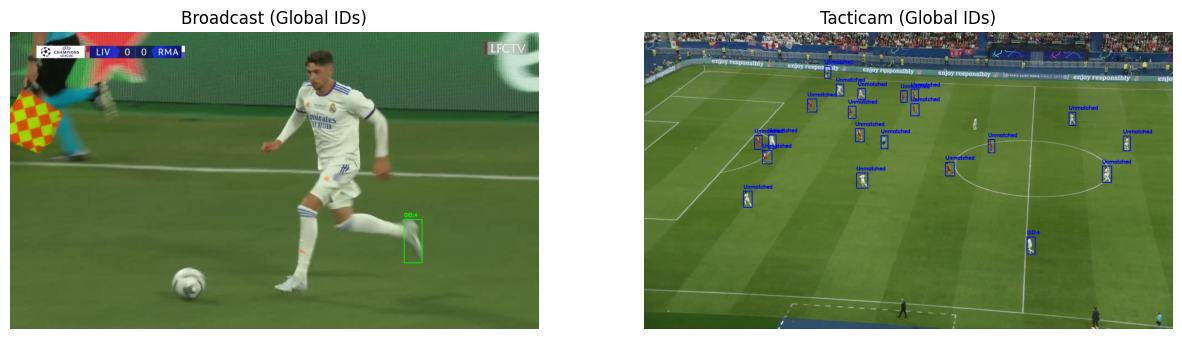

In [26]:

# Visualization for a Specific Frame
frame_num = 1  # Change as per the need do hit and trial for differnt frames


frame_mapping = mapping_df[mapping_df['frame'] == frame_num]
bid_to_gid = dict(zip(frame_mapping['broadcast_id'], frame_mapping['global_id']))
tid_to_gid = dict(zip(frame_mapping['tacticam_id'], frame_mapping['global_id']))

# Load frames from videos
broadcast_cap = cv2.VideoCapture('videos/broadcast.mp4')
tacticam_cap = cv2.VideoCapture('videos/tacticam.mp4')
broadcast_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
tacticam_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num + tacticam_overlap_start)
ret_b, broadcast_frame = broadcast_cap.read()
ret_t, tacticam_frame = tacticam_cap.read()

# Broadcast detections with global IDs
for _, row in broadcast_df[broadcast_df['frame'] == frame_num].iterrows():
    x1, y1, x2, y2 = map(int, [row['x1'], row['y1'], row['x2'], row['y2']])
    bid = row['track_id']
    gid = bid_to_gid.get(bid, None)
    label = f'GID:{gid}' if gid is not None else 'Unmatched'
    cv2.rectangle(broadcast_frame, (x1, y1), (x2, y2), (0,255,0), 2)
    cv2.putText(broadcast_frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

# Tacticam detections with global IDs
for _, row in tacticam_df[tacticam_df['frame'] == frame_num].iterrows():
    x1, y1, x2, y2 = map(int, [row['x1'], row['y1'], row['x2'], row['y2']])
    tid = row['track_id']
    gid = tid_to_gid.get(tid, None)
    label = f'GID:{gid}' if gid is not None else 'Unmatched'
    cv2.rectangle(tacticam_frame, (x1, y1), (x2, y2), (255,0,0), 2)
    cv2.putText(tacticam_frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

# Images are displayed
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title('Broadcast (Global IDs)')
plt.imshow(cv2.cvtColor(broadcast_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Tacticam (Global IDs)')
plt.imshow(cv2.cvtColor(tacticam_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
